# SETUP
---

## import packages

In [1]:
# ----------------------------------------------------------------#

import numpy as np
import pandas as pd
import seaborn as sns
import time

# ----------------------------------------------------------------#

from matplotlib import pyplot as plt
from scipy import stats as st
from sqlalchemy import create_engine

# ----------------------------------------------------------------#

# sklearn - decision trees
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# sklearn - naive bayes
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB

# sklearn - ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

# sklearn - linear regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

# sklearn - model evaluation
from sklearn.metrics import confusion_matrix as CMX
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold

# sklearn - model preparation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize, scale

# skelearn - nearest neighbor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# sklearn - support vector machine
from sklearn.svm import SVC, SVR

# ----------------------------------------------------------------#

# statsmodels
from statsmodels import api as sm
from statsmodels.tools.eval_measures import mse, rmse

# ----------------------------------------------------------------#

import warnings
warnings.filterwarnings('ignore')

## set plot style

In [2]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to set plot style if no arguments provided
jtplot.style()

## read csv & create data frame

In [3]:
#df = pd.read_csv('nba_all_star_team_prediction_model_7.csv')
#df = pd.read_csv('nba_all_star_team_prediction_model_8.csv')
#df = pd.read_csv('nba_all_star_team_prediction_model_10.csv') ####
#df = pd.read_csv('nba_all_star_team_prediction_model_11.csv')
df = pd.read_csv('nba_all_star_team_prediction_model_12.csv')

if 'index' in df.columns:
    df = df.drop(['index'], axis=1)

if 'level_0' in df.columns:
    df = df.drop(['index'], axis=1)

# drop 1999 data set since there was no All Star Game held due to lockout
#drop_indexes = df[df.Year == 1999].index
#df = df.drop(drop_indexes)

df_orig = df.copy()
df.head()

,AllStar,Year,Player,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,SsnScr,SsnScr_norm,PosGrp,Percentile
0,True,1951,Paul Arizin,NaN,9.2,4.5,13.7,NaN,NaN,NaN,NaN,NaN,0.684184,0.778164,FrontCourt,0.045045
1,False,1951,Curly Armstrong,NaN,-0.3,0.9,0.6,NaN,NaN,NaN,NaN,NaN,0.358346,0.407569,BackCourt,0.666667
2,False,1951,Cliff Barker,NaN,-0.9,0.7,-0.2,NaN,NaN,NaN,NaN,NaN,0.342044,0.389027,BackCourt,0.698413
3,False,1951,Leo Barnhorst,NaN,-0.7,1.9,1.3,NaN,NaN,NaN,NaN,NaN,0.493899,0.561742,FrontCourt,0.279279
4,False,1951,Ed Bartels,NaN,-0.8,0.2,-0.5,NaN,NaN,NaN,NaN,NaN,0.256518,0.291754,FrontCourt,0.882883


# EDA
---

## define model

In [4]:
#feats = list(df.drop(['AllStar','Player','Year'], axis=1).columns)
feats = list(df.drop(['AllStar','Player'], axis=1).columns)
df = df[feats + ['AllStar']]
df = df.dropna()

## define constants

In [5]:
# cross validation parameters
_KFOLD_ = 'skf' # 'skf', 'kf', or 'cv'
_SHUFFLE_ = True
_NUM_SPLITS_ = 10
_TTS_TEST_SIZE_ = 1 / _NUM_SPLITS_

# random forests parameters
_RF_TREES_ = 100

# gradient boosting parameters
_GB_ITER_ = 100
_GB_DEPTH_ = 3
_GB_LOSS_ = 'deviance'

# k nearest neighbor parameters
_KNN_NEIGH_ = 3
_KNN_WEIGHT_='distance'

## define helper functions and variables

`df_cv_summ` will hold the summary information for the cross validation results

In [6]:
df_cv_summ = pd.DataFrame(columns=['desc','time','max','min','mean','median','stdev','fold0','fold1','fold2','fold3','fold4','fold5','fold6','fold7','fold8','fold9'])
df_cv_summ

,desc,time,max,min,mean,median,stdev,fold0,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9


`df_cm_summ` will hold the summary information for the confusion matrix results

In [7]:
df_cm_summ = pd.DataFrame(columns=['desc','accuracy','mismatch','false_positive','false_negative','sensitivity','specificity'])
df_cm_summ

,desc,accuracy,mismatch,false_positive,false_negative,sensitivity,specificity


`run_cv(...)`
- execute sklearn `cross_val_score`
- print the confusion matrix summary information
- update confusion matrix summary dataframe

In [8]:
def run_cv(desc, clf, X, Y, k_fold, shuffle_, num_splits, print_summary=False, show_heatmap=False, **kwargs):  
    # start timer
    start_time = time.time()
    
    # stratified kfold
    if k_fold == 'skf':
        skf = StratifiedKFold(shuffle=shuffle_, n_splits=num_splits)
        skf.get_n_splits(X, Y)        
        cv = cross_val_score(clf, X, Y, cv=skf)
        print(f'=== {desc} :: cross_val_score with skf fold strategy, shuffle={shuffle_}, splits={num_splits} ===')
    
    # regular kfold
    elif k_fold == 'kf':
        kf = KFold(shuffle=shuffle_, n_splits=num_splits)
        kf.get_n_splits(X, Y)
        cv = cross_val_score(clf, X, Y, cv=kf)
        print(f'=== {desc} :: cross_val_score with kf fold strategy, shuffle={shuffle_}, splits={num_splits} ===')
    
    # cross_val_score default fold strategy
    else:
        cv = cross_val_score(clf, X, Y, cv=num_splits)
        print(f'=== {desc} :: cross_val_score with default fold strategy, shuffle={shuffle_}, splits={num_splits} ===')
    
    # calculate elapsed time
    elapsed = (time.time() - start_time)

    # update cross validation summary data frame
    global df_cv_summ
    df_cv_summ = df_cv_summ.append({
        'desc'   : desc,
        'time'   : elapsed,
        'max'    : np.max(cv),
        'min'    : np.min(cv),
        'mean'   : np.mean(cv),
        'median' : np.median(cv),
        'stdev'  : np.std(cv),
        'fold0'  : list(cv)[0],
        'fold1'  : list(cv)[1],
        'fold2'  : list(cv)[2],
        'fold3'  : list(cv)[3],
        'fold4'  : list(cv)[4],
        'fold5'  : list(cv)[5],
        'fold6'  : list(cv)[6],
        'fold7'  : list(cv)[7],
        'fold8'  : list(cv)[8],
        'fold9'  : list(cv)[9]
    }, ignore_index=True)
    
    # print summary of cross validation results
    if print_summary:
        print('10-fold cross-validation')
        print('---------------------------------------')
        print(f'max: {np.max(cv)*100:.2f}%')
        print(f'min: {np.min(cv)*100:.2f}%')
        print(f'mean: {np.mean(cv)*100:.2f}%')
        print(f'median: {np.median(cv)*100:.2f}%')
        print(f'stdev: {np.std(cv)*100:.2f}%')
        print(f'execution time: {elapsed:.4f} seconds')
    
    '''if print_csv:
        # print csv format
        print()
        print(elapsed,',',','.join([str(x) for x in [np.max(cv),np.min(cv),np.mean(cv),np.median(cv),np.std(cv)]]),',',','.join([str(x) for x in (list(cv))]))'''
    
    # show Seaborn heatmap of cross validation results
    if show_heatmap:
        sns.heatmap(pd.DataFrame(cv), cmap='RdYlGn', square=True, linewidth=0.5, annot=True)

`run_cm(...)`
- execute the sklearn `confusion_matrix`
- print the confusion matrix summary information
- update confusion matrix summary dataframe

In [9]:
def run_cm(desc, Y, y_pred, print_summary=False):
    result = CMX(Y, y_pred)
    
    if print_summary:
        print('Confusion Matrix Summary')
        print(desc)
        print('------------------------')
        print(f'Type I Error (false positive) : {result[0][1]}/{np.sum(result[0])}, {result[0][1]/np.sum(result[0])*100:.2f}%')
        print(f'Type II Error (false negative): {result[1][0]}/{np.sum(result[1])}, {result[1][0]/np.sum(result[1])*100:.2f}%')
        print(f'Sensitivity                   : {result[1][1]}/{np.sum(result[1])}, {result[1][1]/np.sum(result[1])*100:.2f}%')
        print(f'Specificity                   : {result[0][0]}/{np.sum(result[0])}, {result[0][0]/np.sum(result[0])*100:.2f}%')
        
    # update confusion matrix summary dataframe
    global df_cm_summ
    df_cm_summ = df_cm_summ.append(
        {
            'desc'          : desc,
            'accuracy'      : 100-((result[0][1]+result[1][0])/(np.sum(result[0])+np.sum(result[1]))*100),
            'mismatch'      : (result[0][1]+result[1][0])/(np.sum(result[0])+np.sum(result[1]))*100,
            'false_positive': result[0][1]/np.sum(result[0])*100,
            'false_negative': result[1][0]/np.sum(result[1])*100,
            'sensitivity'   : result[1][1]/np.sum(result[1])*100,
            'specificity'   : result[0][0]/np.sum(result[0])*100
        }, ignore_index=True)
    
    print(f'=== {desc} :: confusion_matrix ===')

In [10]:
def run_classifier(desc, X, Y, clf, print_summary=False, show_heatmap=False, **kwargs):
    X = pd.get_dummies(X, drop_first=True)
    
    # ----------------------#
    # initialize classifier #
    # ----------------------#
    
    # naive bayes (Bernoulli) classifier
    if clf in ['naive_bayes','nb']:
        clf = BernoulliNB()
        print(f'Executing Bernoulli Naive Bayes classification on {desc}')
    
    # random forests classifier
    elif clf in ['random_forests', 'rf']:        
        clf = RandomForestClassifier(n_estimators=_RF_TREES_)
        print(f'Executing Random Forests classification on {desc} with {_RF_TREES_} trees')
    
    # gradient boosting classifer
    elif clf in ['gradient_boosting', 'gb']:            
        clf = GradientBoostingClassifier(n_estimators=_GB_ITER_, max_depth=_GB_DEPTH_, loss=_GB_LOSS_)
        print(f'Executing Gradient Boosting classification on {desc} with {_GB_ITER_} iterations, {_GB_DEPTH_} max depth and using {_GB_LOSS_} loss function')
    
    # k nearest neighbor classifier
    elif clf in ['k_nearest_neighbor', 'knn']:          
        clf = KNeighborsClassifier(n_neighbors=_KNN_NEIGH_, weights=_KNN_WEIGHT_)
        print(f'Executing k-Nearest-Neighbor classification on {desc} using {_KNN_NEIGH_} nearest neighbors and {_KNN_WEIGHT_} weighting')
    else:
        raise f'Unknown classifier: {clf}'
        
    # ---------------#
    # evaluate model #
    # ---------------#
    
    # cross-validation
    run_cv(desc, clf, X, Y, k_fold=_KFOLD_, shuffle_=_SHUFFLE_, num_splits=_NUM_SPLITS_)

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=_TTS_TEST_SIZE_)

    # execute fit on train dataset
    clf.fit(X_train, y_train)

    # get predictions on test dataset
    y_pred = clf.predict(X_test)

    # confusion matrix
    run_cm(desc, y_test, y_pred)
    print('')

In [11]:
def summary_heatmaps(data, plot_title='Summary Heatmap', figsize_w=8, figsize_h=8, xtick_rot=0, ytick_rot=0, cmap='RdYlGn'):
    plt.rcParams['figure.figsize'] = (figsize_w,figsize_h)
    sns.heatmap(data, cmap=cmap, square=True, linewidth=0.5, annot=True)#, vmin=0.8, vmax=1)

    plt.xticks(rotation=xtick_rot)
    plt.yticks(rotation=ytick_rot)

    plt.title(label=plot_title, fontsize=16)

    plt.tight_layout
    plt.show()

# UNBALANCED CLASSIFICATION
---

In [12]:
X = df[feats]
Y = df.AllStar

# naive bayes
run_classifier('bnb_unb', X, Y, 'nb')
run_classifier('rfc_unb', X, Y, 'rf')
run_classifier('gbc_unb', X, Y, 'gb', False, False, gb_iter=500, gb_max_depth=2)
run_classifier('knn_unb', X, Y, 'knn', False, False, knn_num_neigh=3, knn_weight='distance')

Executing Bernoulli Naive Bayes classification on bnb_unb
=== bnb_unb :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== bnb_unb :: confusion_matrix ===

Executing Random Forests classification on rfc_unb with 100 trees
=== rfc_unb :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== rfc_unb :: confusion_matrix ===

Executing Gradient Boosting classification on gbc_unb with 100 iterations, 3 max depth and using deviance loss function
=== gbc_unb :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== gbc_unb :: confusion_matrix ===

Executing k-Nearest-Neighbor classification on knn_unb using 3 nearest neighbors and distance weighting
=== knn_unb :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== knn_unb :: confusion_matrix ===



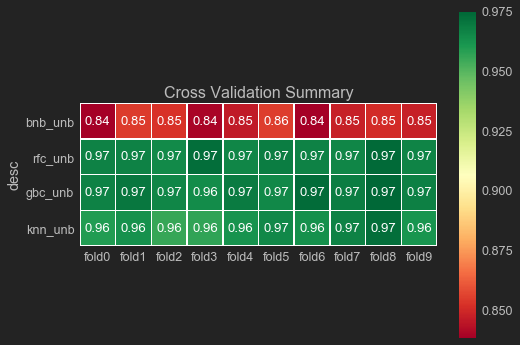

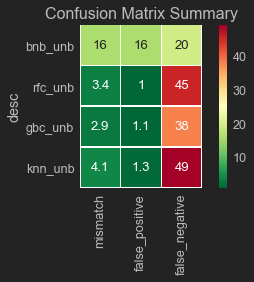

In [13]:
summary_heatmaps(df_cv_summ.set_index('desc').drop(['time','max','min','mean','median','stdev'], axis=1), 
                plot_title='Cross Validation Summary', figsize_w=8, figsize_h=6)
summary_heatmaps(df_cm_summ.set_index('desc').drop(['accuracy','sensitivity','specificity'], axis=1), 
                plot_title='Confusion Matrix Summary', figsize_w=6, figsize_h=3, xtick_rot=90, cmap='RdYlGn_r')


# BALANCED CLASSIFICATION - UNDERSAMPLING MAJORITY CLASS
---

19255


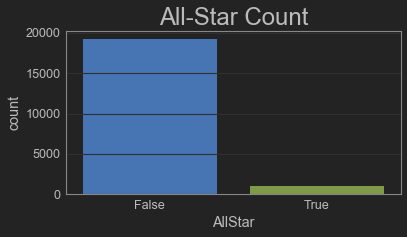

In [14]:
print(df[~df.AllStar].AllStar.count())
sns.countplot(x='AllStar', data=df)
plt.title('All-Star Count', fontsize=24)
plt.show()

1030
1030
2060


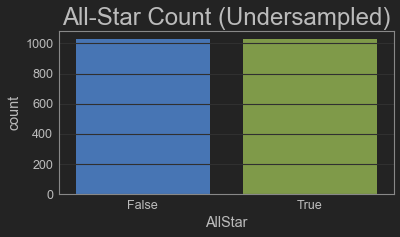

In [15]:
df_allstar = df[df.AllStar]
num_allstars = len(df_allstar)
print(num_allstars)

df_nonallstar = df[~df.AllStar].sample(n=num_allstars)
print(len(df_nonallstar))

df_bal_und = pd.concat([df_allstar, df_nonallstar])
print(len(df_bal_und))

sns.countplot(x='AllStar', data=df_bal_und)
plt.title('All-Star Count (Undersampled)', fontsize=24)
plt.show()

In [16]:
# clear summary dataframes
df_cv_summ = pd.DataFrame(columns=['desc','time','max','min','mean','median','stdev','fold0','fold1','fold2','fold3','fold4','fold5','fold6','fold7','fold8','fold9'])
df_cm_summ = pd.DataFrame(columns=['desc','accuracy','mismatch','false_positive','false_negative','sensitivity','specificity'])


X = df_bal_und[feats]
Y = df_bal_und.AllStar

run_classifier('bnb_bal_und', X, Y, 'nb')
run_classifier('rfc_bal_und', X, Y, 'rf')
run_classifier('gbc_bal_und', X, Y, 'gb', False, False, gb_iter=500, gb_max_depth=2)
run_classifier('knn_bal_und', X, Y, 'knn', False, False, knn_num_neigh=3, knn_weight='distance')


Executing Bernoulli Naive Bayes classification on bnb_bal_und
=== bnb_bal_und :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== bnb_bal_und :: confusion_matrix ===

Executing Random Forests classification on rfc_bal_und with 100 trees
=== rfc_bal_und :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== rfc_bal_und :: confusion_matrix ===

Executing Gradient Boosting classification on gbc_bal_und with 100 iterations, 3 max depth and using deviance loss function
=== gbc_bal_und :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== gbc_bal_und :: confusion_matrix ===

Executing k-Nearest-Neighbor classification on knn_bal_und using 3 nearest neighbors and distance weighting
=== knn_bal_und :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== knn_bal_und :: confusion_matrix ===



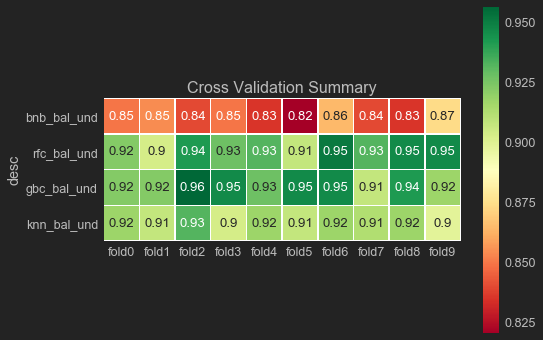

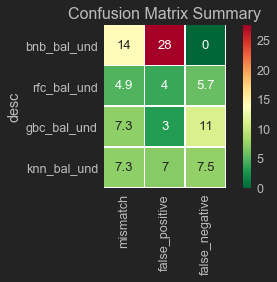

In [17]:
summary_heatmaps(df_cv_summ.set_index('desc').drop(['time','max','min','mean','median','stdev'], axis=1), 
                plot_title='Cross Validation Summary', figsize_w=8, figsize_h=6)
summary_heatmaps(df_cm_summ.set_index('desc').drop(['accuracy','sensitivity','specificity'], axis=1), 
                plot_title='Confusion Matrix Summary', figsize_w=6, figsize_h=3, xtick_rot=90, cmap='RdYlGn_r')

# BALANCED CLASSIFICATION - SMOTE
---

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
sm = SMOTE()

X = df[feats]
X = pd.get_dummies(X, drop_first=True)
Y = df.AllStar

print(len(X))
print(len(Y[Y]))
print(len(Y[~Y]))

X_sm, Y_sm = sm.fit_sample(X, Y.ravel())

print(len(X_sm))
print(len(Y_sm[Y_sm]))
print(len(Y_sm[~Y_sm]))

20285
1030
19255
38510
19255
19255


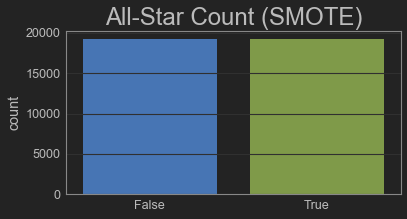

In [20]:
sns.countplot(Y_sm)
plt.title('All-Star Count (SMOTE)', fontsize=24)
plt.show()

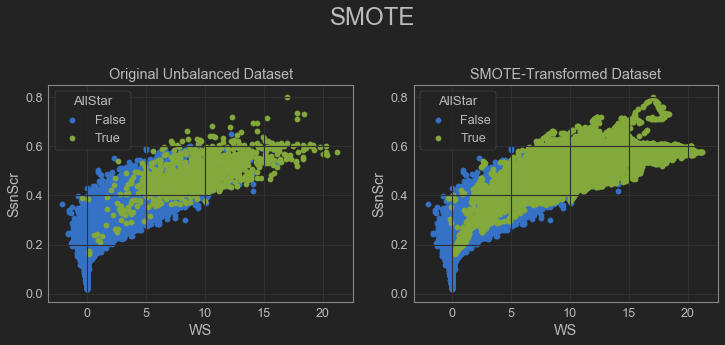

In [21]:
plt.rcParams['figure.figsize'] = (12,4)

df_ysm = pd.DataFrame(Y_sm)
df_ysm.columns = ['AllStar']
df_sm = pd.concat([X_sm,df_ysm], axis=1)

#df_sm.head()

plt.subplot(1,2,1)
plt.scatter(df[~df.AllStar].WS, df[~df.AllStar].SsnScr, label='False')
plt.scatter(df[df.AllStar].WS, df[df.AllStar].SsnScr, label='True')
plt.xlabel('WS')
plt.ylabel('SsnScr')
plt.legend(title='AllStar')
plt.title('Original Unbalanced Dataset')



plt.subplot(1,2,2)
plt.scatter(df_sm[~df_sm.AllStar].WS, df_sm[~df_sm.AllStar].SsnScr, label='False')
plt.scatter(df_sm[df_sm.AllStar].WS, df_sm[df_sm.AllStar].SsnScr, label='True')
plt.xlabel('WS')
plt.ylabel('SsnScr')
plt.legend(title='AllStar')
plt.title('SMOTE-Transformed Dataset')

plt.suptitle('SMOTE', y=1.15, fontsize=24)
plt.show()


In [22]:
# clear summary dataframes
df_cv_summ = pd.DataFrame(columns=['desc','time','max','min','mean','median','stdev','fold0','fold1','fold2','fold3','fold4','fold5','fold6','fold7','fold8','fold9'])
df_cm_summ = pd.DataFrame(columns=['desc','accuracy','mismatch','false_positive','false_negative','sensitivity','specificity'])


X = X_sm
Y = Y_sm

run_classifier('bnb_bal_sm', X, Y, 'nb')
run_classifier('rfc_bal_sm', X, Y, 'rf')
run_classifier('gbc_bal_sm', X, Y, 'gb', False, False, gb_iter=500, gb_max_depth=2)
run_classifier('knn_bal_sm', X, Y, 'knn', False, False, knn_num_neigh=3, knn_weight='distance')

Executing Bernoulli Naive Bayes classification on bnb_bal_sm
=== bnb_bal_sm :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== bnb_bal_sm :: confusion_matrix ===

Executing Random Forests classification on rfc_bal_sm with 100 trees
=== rfc_bal_sm :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== rfc_bal_sm :: confusion_matrix ===

Executing Gradient Boosting classification on gbc_bal_sm with 100 iterations, 3 max depth and using deviance loss function
=== gbc_bal_sm :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== gbc_bal_sm :: confusion_matrix ===

Executing k-Nearest-Neighbor classification on knn_bal_sm using 3 nearest neighbors and distance weighting
=== knn_bal_sm :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== knn_bal_sm :: confusion_matrix ===



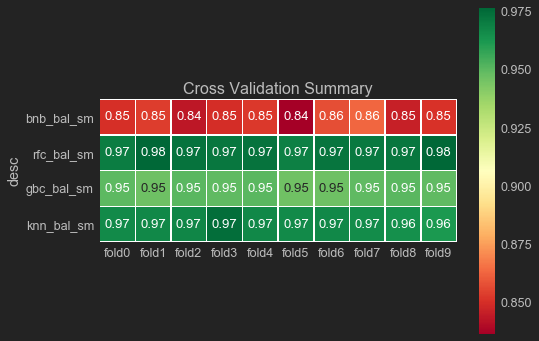

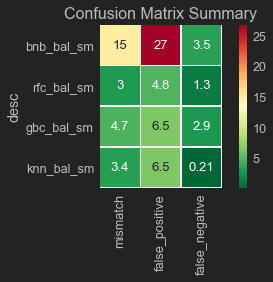

In [23]:
summary_heatmaps(df_cv_summ.set_index('desc').drop(['time','max','min','mean','median','stdev'], axis=1), 
                plot_title='Cross Validation Summary', figsize_w=8, figsize_h=6)
summary_heatmaps(df_cm_summ.set_index('desc').drop(['accuracy','sensitivity','specificity'], axis=1), 
                plot_title='Confusion Matrix Summary', figsize_w=6, figsize_h=3, xtick_rot=90, cmap='RdYlGn_r')

# FEATURE IMPORTANCE
---

## random forests feature importance

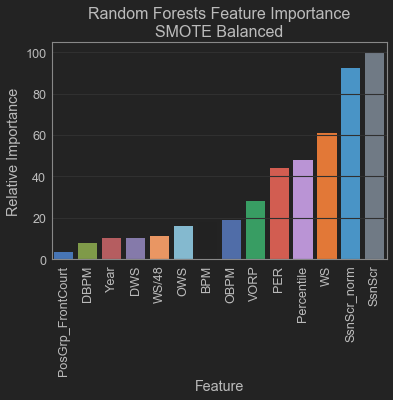

In [ ]:
plt.rcParams['figure.figsize'] = (6,4)

X = X_sm
Y = Y_sm

rfc = RandomForestClassifier(n_estimators=_RF_TREES_)
rfc.fit(X,Y)

feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# get sort IDs to align with feature name
sorted_idx = np.argsort(feature_importance)

sns.barplot(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.ylabel('Relative Importance')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.title('Random Forests Feature Importance\nSMOTE Balanced', fontsize=16)

plt.show()

In [ ]:
# clear summary dataframes
df_cv_summ = pd.DataFrame(columns=['desc','time','max','min','mean','median','stdev','fold0','fold1','fold2','fold3','fold4','fold5','fold6','fold7','fold8','fold9'])
df_cm_summ = pd.DataFrame(columns=['desc','accuracy','mismatch','false_positive','false_negative','sensitivity','specificity'])


X = X_sm[['SsnScr_norm','SsnScr','WS','PER']]
Y = Y_sm

run_classifier('bnb_bal_sm', X, Y, 'nb')
run_classifier('rfc_bal_sm', X, Y, 'rf')
run_classifier('gbc_bal_sm', X, Y, 'gb', False, False, gb_iter=500, gb_max_depth=2)
run_classifier('knn_bal_sm', X, Y, 'knn', False, False, knn_num_neigh=3, knn_weight='distance')

Executing Bernoulli Naive Bayes classification on bnb_bal_sm
=== bnb_bal_sm :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== bnb_bal_sm :: confusion_matrix ===

Executing Random Forests classification on rfc_bal_sm with 100 trees
=== rfc_bal_sm :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== rfc_bal_sm :: confusion_matrix ===

Executing Gradient Boosting classification on gbc_bal_sm with 100 iterations, 3 max depth and using deviance loss function
=== gbc_bal_sm :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== gbc_bal_sm :: confusion_matrix ===

Executing k-Nearest-Neighbor classification on knn_bal_sm using 3 nearest neighbors and distance weighting
=== knn_bal_sm :: cross_val_score with skf fold strategy, shuffle=True, splits=10 ===
=== knn_bal_sm :: confusion_matrix ===



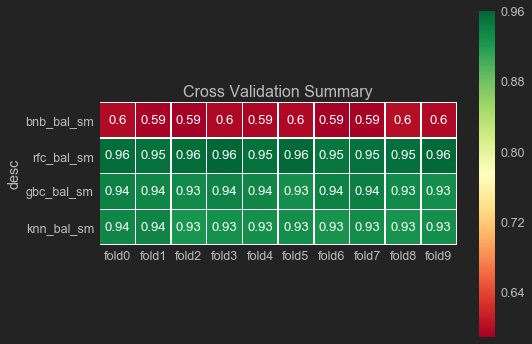

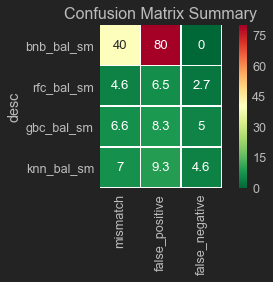

In [ ]:
summary_heatmaps(df_cv_summ.set_index('desc').drop(['time','max','min','mean','median','stdev'], axis=1), 
                plot_title='Cross Validation Summary', figsize_w=8, figsize_h=6)
summary_heatmaps(df_cm_summ.set_index('desc').drop(['accuracy','sensitivity','specificity'], axis=1), 
                plot_title='Confusion Matrix Summary', figsize_w=6, figsize_h=3, xtick_rot=90, cmap='RdYlGn_r')

# PREDICTING WITH NEW DATA
---

In [ ]:
df_new_ = pd.read_csv('new_data_2018_2019.csv')
df_new = df_new_[feats + ['AllStar']]
df_new = df_new.dropna().reset_index()

X = X_sm
Y = Y_sm

rfc = RandomForestClassifier(n_estimators=_RF_TREES_)
rfc.fit(X,Y)

X_new = df_new[feats]
X_new = pd.get_dummies(X_new, drop_first=True)

y_pred = rfc.predict(X_new)



In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['Predicted']
y_pred[y_pred.Predicted].count()

In [ ]:
df_new = pd.concat([df_new_,y_pred], axis=1)

print('2019_true_positive',df_new[(df_new.Year == 2019) & (df_new.Predicted) & (df_new.AllStar)].Player.count())
print('2018_true_positive',df_new[(df_new.Year == 2018) & (df_new.Predicted) & (df_new.AllStar)].Player.count())
print('2019_true_negative',df_new[(df_new.Year == 2019) & (~df_new.Predicted) & (~df_new.AllStar)].Player.count())
print('2018_true_negative',df_new[(df_new.Year == 2018) & (~df_new.Predicted) & (~df_new.AllStar)].Player.count())

print('')

print('2019_false_positive',df_new[(df_new.Year == 2019) & (df_new.Predicted) & (~df_new.AllStar)].Player.count())
print('2018_false_positive',df_new[(df_new.Year == 2018) & (df_new.Predicted) & (~df_new.AllStar)].Player.count())
print('2019_false_negative',df_new[(df_new.Year == 2019) & (~df_new.Predicted) & (df_new.AllStar)].Player.count())
print('2018_false_negative',df_new[(df_new.Year == 2018) & (~df_new.Predicted) & (df_new.AllStar)].Player.count())

In [ ]:
# 2019 frontcourt
df_new[(df_new.Year == 2019) & (df_new.PosGrp == 'FrontCourt')].sort_values(by=['SsnScr_norm'], ascending=False).head(24)

In [ ]:
# 2019 backcourt
df_new[(df_new.Year == 2019) & (df_new.PosGrp == 'BackCourt')].sort_values(by=['SsnScr_norm'], ascending=False).head(24)

In [ ]:
# 2018 frontcourt
df_new[(df_new.Year == 2018) & (df_new.PosGrp == 'FrontCourt')].sort_values(by=['SsnScr_norm'], ascending=False).head(24)

In [ ]:
# 2018 backcourt
df_new[(df_new.Year == 2018) & (df_new.PosGrp == 'BackCourt')].sort_values(by=['SsnScr_norm'], ascending=False).head(24)

In [ ]:
plt.rcParams['figure.figsize'] = (12,4)

plt.subplot(1,2,1)
plt.scatter(df_new[(df_new.Year == 2018) & ~df_new.AllStar & ~df_new.Predicted].Percentile, df_new[(df_new.Year == 2018) & ~df_new.AllStar & ~df_new.Predicted].SsnScr_norm, label='true_negatives')
plt.scatter(df_new[(df_new.Year == 2018) & df_new.AllStar & df_new.Predicted].Percentile, df_new[(df_new.Year == 2018) & df_new.AllStar & df_new.Predicted].SsnScr_norm, label='true_positives')
plt.scatter(df_new[(df_new.Year == 2018) & ~df_new.AllStar & df_new.Predicted].Percentile, df_new[(df_new.Year == 2018) & ~df_new.AllStar & df_new.Predicted].SsnScr_norm, label='false_positives')
plt.scatter(df_new[(df_new.Year == 2018) & df_new.AllStar & ~df_new.Predicted].Percentile, df_new[(df_new.Year == 2018) & df_new.AllStar & ~df_new.Predicted].SsnScr_norm, label='false_negatives')
plt.xlabel('Percentile')
plt.ylabel('SsnScr_norm')
plt.legend(loc=1)
plt.title('2018')



plt.subplot(1,2,2)
plt.scatter(df_new[(df_new.Year == 2019) & ~df_new.AllStar & ~df_new.Predicted].Percentile, df_new[(df_new.Year == 2019) & ~df_new.AllStar & ~df_new.Predicted].SsnScr_norm, label='true_negatives')
plt.scatter(df_new[(df_new.Year == 2019) & df_new.AllStar & df_new.Predicted].Percentile, df_new[(df_new.Year == 2019) & df_new.AllStar & df_new.Predicted].SsnScr_norm, label='true_positives')
plt.scatter(df_new[(df_new.Year == 2019) & ~df_new.AllStar & df_new.Predicted].Percentile, df_new[(df_new.Year == 2019) & ~df_new.AllStar & df_new.Predicted].SsnScr_norm, label='false_positives')
plt.scatter(df_new[(df_new.Year == 2019) & df_new.AllStar & ~df_new.Predicted].Percentile, df_new[(df_new.Year == 2019) & df_new.AllStar & ~df_new.Predicted].SsnScr_norm, label='false_negatives')
plt.xlabel('Percentile')
plt.ylabel('SsnScr_norm')
plt.legend(loc=1)
plt.title('2019')

plt.suptitle('Prediction Results for 2018/2019 Data')
plt.show()

In [ ]:
plt.scatter(df[~df.AllStar].Percentile, df[~df.AllStar].SsnScr_norm, label='False')
plt.scatter(df[df.AllStar].Percentile, df[df.AllStar].SsnScr_norm, label='True')
plt.xlabel('Percentile')
plt.ylabel('SsnScr_norm')

plt.legend(title='AllStar')
plt.show()